# Import Packages and Load Datasets:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

In [2]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
train = train_raw.copy()
test = test_raw.copy()

In [3]:
train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [4]:
test.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban


In [5]:
train.drop_duplicates(keep='first', inplace=True)

In [6]:
train.drop('Loan_ID', axis=1, inplace=True)
test.drop('Loan_ID', axis=1, inplace=True)

# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [8]:
for col in train.columns:
    print('Number of unique values in ' + col + ' are: ' +str(train[col].nunique()))

Number of unique values in Gender are: 2
Number of unique values in Married are: 2
Number of unique values in Dependents are: 4
Number of unique values in Education are: 2
Number of unique values in Self_Employed are: 2
Number of unique values in ApplicantIncome are: 505
Number of unique values in CoapplicantIncome are: 287
Number of unique values in LoanAmount are: 203
Number of unique values in Loan_Amount_Term are: 10
Number of unique values in Credit_History are: 2
Number of unique values in Property_Area are: 3
Number of unique values in Loan_Status are: 2


In [9]:
for item in [train, test]:
    print(item.isnull().sum())
    print('=================')

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


<AxesSubplot:>

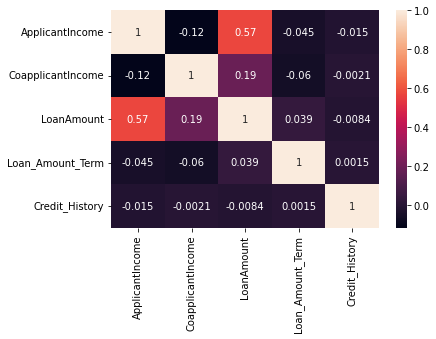

In [10]:
sns.heatmap(train.corr(), annot=True)

# Fill Missing Values

In [11]:
# Categorical Features
train['Gender'] = train['Gender'].ffill().bfill()
test['Gender'] = test['Gender'].ffill().bfill()
train['Married'].fillna('No', inplace=True)
train['Dependents'].fillna('0', inplace=True)
test['Dependents'].fillna('0', inplace=True)
train['Self_Employed'].fillna('No', inplace=True)
test['Self_Employed'].fillna('No', inplace=True)
train['Credit_History'].replace({1.:'Yes', 0.:'No'}, inplace=True)
test['Credit_History'].replace({1.:'Yes', 0.:'No'}, inplace=True)
train['Credit_History'].fillna('No', inplace=True)
test['Credit_History'].fillna('No', inplace=True)

In [12]:
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].median(), inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(), inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(), inplace=True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 62.4+ KB


# Split Data into Features and Target

In [14]:
X_train = train.drop('Loan_Status', axis=1)

In [15]:
y_train = train['Loan_Status'].replace({'Y': 1, 'N': 0})

In [16]:
X_test = test.copy()

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 57.6+ KB


In [18]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_num = X_train.select_dtypes(include=['int64','float64'])
X_test_cat = X_test.select_dtypes(include='object')
X_test_num = X_test.select_dtypes(include=['int64','float64'])

In [19]:
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          367 non-null    object
 1   Married         367 non-null    object
 2   Dependents      367 non-null    object
 3   Education       367 non-null    object
 4   Self_Employed   367 non-null    object
 5   Credit_History  367 non-null    object
 6   Property_Area   367 non-null    object
dtypes: object(7)
memory usage: 20.2+ KB


# Data Encoding: pd.get_dummies

In [20]:
def df_encode(encode_data):
    encode_data = pd.get_dummies(encode_data)
    return encode_data

In [21]:
X_train_cat_encoded = df_encode(X_train_cat)
X_test_cat_encoded = df_encode(X_test_cat)

In [22]:
X_train_cat_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Gender_Female            614 non-null    uint8
 1   Gender_Male              614 non-null    uint8
 2   Married_No               614 non-null    uint8
 3   Married_Yes              614 non-null    uint8
 4   Dependents_0             614 non-null    uint8
 5   Dependents_1             614 non-null    uint8
 6   Dependents_2             614 non-null    uint8
 7   Dependents_3+            614 non-null    uint8
 8   Education_Graduate       614 non-null    uint8
 9   Education_Not Graduate   614 non-null    uint8
 10  Self_Employed_No         614 non-null    uint8
 11  Self_Employed_Yes        614 non-null    uint8
 12  Credit_History_No        614 non-null    uint8
 13  Credit_History_Yes       614 non-null    uint8
 14  Property_Area_Rural      614 non-null    uint8
 15  Proper

# Data Scaling with RobustScaler, MinMaxScaler, and StandardScaler

In [23]:
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train_num)
X_test_scaled = mms.transform(X_test_num)

In [24]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [25]:
X_train = pd.concat([X_train_cat_encoded, X_train_scaled], axis=1)
X_test = pd.concat([X_test_cat_encoded, X_test_scaled], axis=1)

In [26]:
X_train.rename(columns={0:'ApplicantIncome', 1:'CoapplicantIncome', 2:'LoanAmount', 3:'Loan_Amount_Term'}, inplace=True)
X_test.rename(columns={0:'ApplicantIncome', 1:'CoapplicantIncome', 2:'LoanAmount', 3:'Loan_Amount_Term'}, inplace=True)

In [27]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [28]:
y_train.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [29]:
# Value for scale_pos_weight
192/422

0.4549763033175355

# Baseline Model and Hyperparameter Tuning

In [30]:
xgbc = XGBClassifier(scale_pos_weight=.45, booster='gbtree', objective='binary:logistic', max_depth=8, n_estimators=102, use_label_encoder=False, random_state=7)
lgbmc = LGBMClassifier(scale_pos_weight=.45, objective='binary', learning_rate=.0079, n_estimators=85, random_state=7)
catc = CatBoostClassifier(scale_pos_weight=.45, random_state=7)
lrc = LogisticRegression(solver='liblinear', penalty='l2', random_state=7)
rfc = RandomForestClassifier(n_estimators=64, criterion='entropy', max_depth=3, random_state=7)

In [31]:
def random_grid_search(model, params):
    r_grid = RandomizedSearchCV(model, params, n_iter=50, cv=4, n_jobs=-1)
    r_grid.fit(X_train, y_train)
    best_params = r_grid.best_params_
    print('Best params', best_params)
    best_score = r_grid.best_score_
    print('Best score:', best_score)

In [32]:
def grid_search(model, params):
    grid = GridSearchCV(model, params, cv=4, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    print('Best params', best_params)
    best_score = grid.best_score_
    print('Best score:', best_score) 

In [33]:
#params={}

In [34]:
#grid_search(rfc, params)

In [35]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, random_state=7)

In [36]:
def check(model):
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    print('Accuracy score:', accuracy_score(ypred, ytest))

In [37]:
Classifiers = {'0.XGBoost' : XGBClassifier(scale_pos_weight=.45, booster='gbtree', objective='binary:logistic', 
                                           max_depth=8, n_estimators=102, use_label_encoder=False, random_state=7),
               
               '1.CatBoost' : CatBoostClassifier(scale_pos_weight=.45, random_state=7),
               
               '2.LightGBM' : LGBMClassifier(scale_pos_weight=.45, objective='binary',
                                             learning_rate=.0079, n_estimators=85, random_state=7),
               
               '3.LogisticRegression' : LogisticRegression(solver='liblinear', penalty='l2', random_state=7),
               
               '4.RandomForest' : RandomForestClassifier(n_estimators=64, criterion='entropy', max_depth=3, random_state=7)
 }

# Build Ensemble using Voting Classifier

In [44]:
ensemble_model = VotingClassifier(estimators=[('XGBoost_Best', list(Classifiers.values())[0]), 
                                              ('CatBoost_Best', list(Classifiers.values())[1]),
                                              ('LightGBM_Best', list(Classifiers.values())[2]),
                                              ('LogisticRegression_Best', list(Classifiers.values())[2]),
                                              ('RandomForest_Best', list(Classifiers.values())[2]),
                                             ], 
                                              voting='hard', n_jobs=-1)

ensemble_model.fit(X_train, y_train) 

pred = ensemble_model.predict(X_test)